In [2]:
import pandas as pd
import numpy as np
import recommendations
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
df = pd.read_csv('./processed_data.csv')
# df = df[['Course Code', 'Student Number', 'Letter Grade', 'Semester', 'Course Credit']]
df = df[['Course Title', 'Student Number', 'Grades', 'Course Semester', 'Course Credit']]
df

,Course Title,Student Number,Grades,Course Semester,Course Credit
0,Ideological and Moral Cultivation and Legal Fo...,0,4,1,2.5
1,Success: Career Planning,0,3,1,1.0
2,Introduction to Computer Science,0,1,1,2.0
3,Advanced Mathematics A(1),0,4,1,5.5
4,College English A(1),0,3,1,4.0
...,...,...,...,...,...
19095,J2EE Framework,381,3,6,4.5
19096,Intellectual Property and Software Protection,381,4,7,1.0
19097,Human-Computer Interaction Technology,381,5,7,2.0
19098,Software Development and Testing Training,381,3,7,3.0


In [3]:
grade_mapper = {'A+': 4.1, 'A': 4.0, 'A-': 3.7, 'B+': 3.3, 'B': 3.0, 'B-': 2.7, 'C+': 2.3, 
                'C': 2.0, 'C-': 1.7, 'D+': 1.3, 'D': 1.0, 'D-': 0.5, 'F': 0.0}

In [4]:
semester_data = {}
course_data = {}
for row_idx in df.index:
    course_title = df.iloc[row_idx, 0]
    student_number = df.iloc[row_idx, 1]
    grade = df.iloc[row_idx, 2]
    semester = df.iloc[row_idx, 3]
    course_credit = df.iloc[row_idx, 4]
    
    semester_data.setdefault(semester, {})
    semester_data[semester].setdefault(student_number, {})
    # semester_data[semester][student_number][course_title] = grade_mapper[letter_grade]
    semester_data[semester][student_number][course_title] = grade
    course_data[course_title] = course_credit

In [5]:
def get_gpa(semester_data, student):
    total_weight = 0
    total_credit = 0
    
    for course in semester_data[student]:
        total_weight += semester_data[student][course] * course_data[course]
        total_credit += course_data[course]
    
    return total_weight / total_credit

In [6]:
def get_grade_stats(semester_data, student):
    grade_list = []
    
    for course in semester_data[student]:
        numerical_grade = semester_data[student][course]
        grade_list.append(numerical_grade)
    
    mean = np.mean(grade_list)
    std_dev = np.std(grade_list)
    
    return mean, std_dev

In [7]:
def get_errors(train_semester, test_semester, sim):
    y_true = []
    y_pred = []
    gpa = {}
    
    for student in train_semester:
        gpa[student] = get_gpa(train_semester, student)
        
    for student in train_semester:
        recommended_courses = {}
        recs = recommendations.getRecommendations(train_semester, student, sim, dgpa=True, gpa=gpa, delta=0.7)
            
        for rec_grade, rec_course in recs:
            recommended_courses.setdefault(rec_course, rec_grade)
            
        gpa.setdefault(student, get_gpa(train_semester, student))
        
        if student not in test_semester:
            continue
        
        mean, std_dev = get_grade_stats(train_semester, student)
            
        for course_code in test_semester[student]:
            if course_code in recommended_courses:
                rec_grade = recommended_courses[course_code]
                if rec_grade < mean - (2 * std_dev) or rec_grade > mean + (2 * std_dev):
                    continue
                y_pred.append(rec_grade)
            else:
                rec_grade = gpa[student]
                if rec_grade < mean - (2 * std_dev) or rec_grade > mean + (2 * std_dev):
                    continue
                y_pred.append(rec_grade)
            y_true.append(test_semester[student][course_code])
        
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    return rmse, mae

In [8]:
def predict(semester_data, sim):
    errors = {'rmse': [], 'mae': []}
    train_semester = {}
    for i in range(1, len(sorted(semester_data))):
        new_semester = semester_data[sorted(semester_data)[i-1]]
        for student in new_semester:
            if student in train_semester:
                train_semester[student].update(new_semester[student])
            else:
                train_semester[student] = new_semester[student]
        test_semester = semester_data[sorted(semester_data)[i]]

        # making predictions for every student in training semester
        rmse, mae = get_errors(train_semester, test_semester, sim)

        errors['rmse'].append(rmse)
        errors['mae'].append(mae)
    
    return errors

In [16]:
def weighted_average(errors): 
    #rmse
    a = 1
    sum = 0

    print("weighted average rmse:")
    for i in errors['rmse']:
        a += 1
        if (a == 2):
            sum += 9 * i
        if (a == 3):
            sum += 8 * i
        if (a == 4):
            sum += 7 * i
        if (a == 5):
            sum += 6 * i
        if (a == 6):
            sum += 8 * i
        if (a == 7):
            sum += 4 * i

    weighted_average_rmse = sum / 42
    print(weighted_average_rmse)

    # mae
    a = 1
    sum = 0

    print("weighted average mae:")
    for i in errors['mae']:
        a += 1
        if (a == 2):
            sum += 9 * i
        if (a == 3):
            sum += 8 * i
        if (a == 4):
            sum += 7 * i
        if (a == 5):
            sum += 6 * i
        if (a == 6):
            sum += 8 * i
        if (a == 7):
            sum += 4 * i

    weighted_average_mae = sum / 42
    print(weighted_average_mae)


In [14]:
def plot_errors(errors, sim):
    n = len(errors['rmse'])
    x = np.arange(n)
    fig, ax = plt.subplots(figsize=(11, 5.5))
    rects1 = ax.bar(x - 0.35/2, errors['rmse'], 0.35, label='RMSE')
    rects2 = ax.bar(x + 0.35/2, errors['mae'], 0.35, label='MAE')

    for i, v in enumerate(errors['rmse']):
        ax.text(i - 0.36, v + 0.01, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold')
    for i, v in enumerate(errors['mae']):
        ax.text(i - 0.01, v + 0.01, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold')

    ax.set_ylabel('Error', fontsize=22, fontfamily='serif')
    ax.set_title('Error Metrics with N training semesters ({})'.format(sim), fontsize=22, fontfamily='serif')
    ax.set_xticks(x)
    ax.set_xticklabels(['N={}'.format(i + 1) for i in range(n)], fontsize=22, fontfamily='serif')
    ax.set_yticklabels([round(i, 1) for i in ax.get_yticks()], fontsize=22, fontfamily='serif')
    ax.tick_params(labelsize=22)
    ax.grid(True)
    ax.legend(prop={'size': 18, 'family': 'serif'}, loc='center', bbox_to_anchor=(0.5, -0.15), ncol=2)


In [10]:
results = {}

In [17]:
errors = predict(semester_data, recommendations.sim_distance)
weighted_average(errors)

weighted average rmse:
0.9322556523953041
weighted average mae:
0.7624271802162373


In [20]:
import json
# Your results
results = {
    "chinese 2017 paper": {
        "WeightedAvgRMSE": 0.9322556523953041,
        "WeightedAvgMAE": 0.7624271802162373
    },
}

# Save to JSON file
with open("chinese_2017paper.json", "w") as f:
    json.dump(results, f, indent=4)


/var/folders/s7/jgc_z9fj1tq65hb0wg4tr7lm0000gn/T/ipykernel_35070/4231461160.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(i, 1) for i in ax.get_yticks()], fontsize=22, fontfamily='serif')


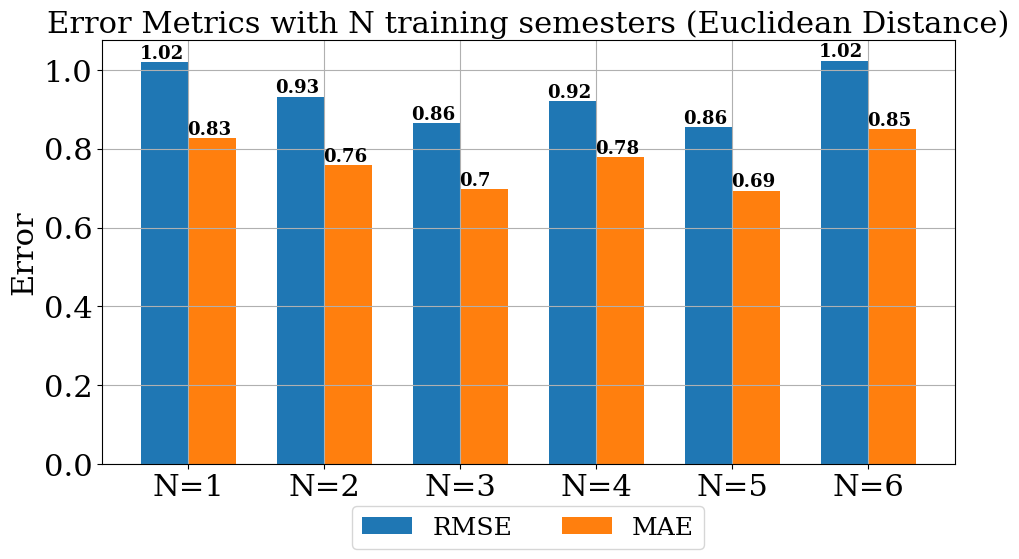

In [15]:
errors = predict(semester_data, recommendations.sim_distance)
results['Euclidean Distance'] = errors
plot_errors(errors, 'Euclidean Distance')

In [13]:
import json
with open('2017 paper.json', 'w') as fw:
    json.dump(results, fw)